<a href="https://colab.research.google.com/github/thuyk39nguyen/AIO/blob/main/Modul6_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem 01: Sentiment Analysis for Financial News**

Chúng ta sẽ xây dựng một mô hình về Text Classfication dùng để phân loại tình hình tin tức tài chính là tích cực (positive), tiêu cực (negative) hay trung lập (neutral) dựa trên một đoạn văn có nội dung về tài chính cho trước.

In [ ]:
!pip install torch nltk unidecode

In [ ]:
import torch
import torch.nn as nn

# Set seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

import matplotlib.pyplot as plt

# NLTK setup
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader

# Sklearn train-test split
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


3. Đọc bộ dữ liệu:

In [ ]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names = headers, encoding ='ISO-8859-1')

Ta có thể xác định được danh sách các class của bài toán bằng phương thức unique() của Pandas, đồng thời ta cũng sẽ đổi class dạng string thành số nguyên đại diện cho ID của
chúng:

In [ ]:
classes = {class_name : idx for idx , class_name in enumerate (df['sentiment'].unique ().tolist())}
df['sentiment'] = df['sentiment'].apply(lambda x: classes [x])

4. Tiền xử lý dữ liệu:

In [ ]:
english_stop_words = stopwords.words ('english')
stemmer = PorterStemmer ()

def text_normalize ( text ):
  text = text.lower ()
  text = unidecode.unidecode ( text )
  text = text.strip ()
  text = re.sub (r'[^\w\s]', '', text )
  text = ''. join ([ word for word in text.split ('') if word not in english_stop_words ])
  text = ''. join ([ stemmer.stem ( word ) for word in text.split ('') ])

  return text

5. Xây dựng bộ từ vựng:
Trong đó, ’UNK’ đại diện cho các từ không thuộc bộ từ vựng và ’PAD’ đại diện cho các ô trống được thêm vào để thỏa mãn độ dài tối thiểu của một văn bản mà ta quy định về sau.

In [ ]:
vocab = []
for sentence in df['content']. tolist () :
  tokens = sentence.split ()
  for token in tokens :
    if token not in vocab :
      vocab.append ( token )

vocab.append ('UNK')
vocab.append ('PAD')
word_to_idx = { word: idx for idx , word in enumerate (vocab)}
vocab_size = len(vocab)

Với bộ từ vựng trên, ta xây dựng hàm transform() dùng để chuyển đổi văn bản thành danh sách các số nguyên như sau:

In [ ]:
def transform (text , word_to_idx , max_seq_len ) :
  tokens = []
  for w in text.split () :
    try :
      w_ids = word_to_idx [w]
    except :
      w_ids = word_to_idx ['UNK']
    tokens.append ( w_ids )

  if len( tokens ) < max_seq_len :
    tokens += [ word_to_idx ['PAD']] * ( max_seq_len - len( tokens ) )
  elif len( tokens ) > max_seq_len :
    tokens = tokens [: max_seq_len ]

  return tokens

6. Chia bộ dữ liệu train, val, test:

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist ()
labels = df['sentiment'].tolist ()

X_train , X_val , y_train , y_val = train_test_split (texts , labels , test_size = val_size , random_state =seed , shuffle = is_shuffle)

X_train , X_test , y_train , y_test = train_test_split (X_train , y_train , test_size = val_size , random_state =seed , shuffle = is_shuffle)

7. Xây dựng pytorch datasets:

In [ ]:
class FinancialNews ( Dataset ) :
  def __init__ (self , X, y, word_to_idx , max_seq_len ,transform = None) :
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__ ( self ) :
    return len( self.texts )

  def __getitem__ (self , idx) :
    text = self.texts [ idx]
    label = self.labels [idx]

    if self.transform :
      text = self.transform (text , self.word_to_idx , self.max_seq_len)
      text = torch.tensor ( text )
    return text , label

In [ ]:
# Sequence length
max_seq_len = 32

# Create datasets for training, validation, and testing
train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

# Batch sizes for training and testing
train_batch_size = 128
test_batch_size = 8

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

9. Xây dựng mô hình:

In [ ]:
import torch
import torch.nn as nn

# Sentiment Classifier model
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)

        # Normalization and regularization layers
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        # Pass through embedding layer
        x = self.embedding(x)

        # Pass through RNN
        x, _ = self.rnn(x)

        # Extract the output of the last time step
        x = x[:, -1, :]

        # Apply normalization, dropout, and fully connected layers
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

Với class trên, ta khai báo mô hình SentimentClassifier:

In [ ]:
# Define model parameters
n_classes = len(list(classes.keys()))  # Number of output classes
embedding_dim = 64                    # Dimension of word embeddings
hidden_size = 64                      # Hidden layer size in RNN
n_layers = 2                          # Number of RNN layers
dropout_prob = 0.2                    # Dropout probability

# Check if CUDA is available for GPU computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the SentimentClassifier model and move it to the appropriate device
model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

10. Cài đặt hàm loss và optimizer:

In [ ]:
lr = 1e-4
epochs = 50

criterion = nn. CrossEntropyLoss ()
optimizer = torch.optim.Adam (model.parameters () , lr=lr)

11. Thực hiện huấn luyện:

In [ ]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    """
    Hàm huấn luyện mô hình với tập dữ liệu huấn luyện và đánh giá trên tập validation.
    """
    train_losses = []  # Lưu trữ loss của từng epoch trong tập huấn luyện
    val_losses = []    # Lưu trữ loss của từng epoch trong tập validation

    # Vòng lặp huấn luyện qua từng epoch
    for epoch in range(epochs):
        model.train()  # Đặt mô hình ở chế độ huấn luyện
        batch_train_losses = []  # Lưu trữ loss của từng batch trong epoch

        for idx, (inputs, labels) in enumerate(train_loader):
            # Đưa dữ liệu vào thiết bị (GPU hoặc CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass và cập nhật trọng số
            loss.backward()
            optimizer.step()

            # Ghi lại loss của batch
            batch_train_losses.append(loss.item())

        # Tính loss trung bình cho epoch
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        # Đánh giá trên tập validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        # In kết quả
        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [ ]:
def evaluate(model, dataloader, criterion, device):
    """
    Đánh giá mô hình trên tập validation hoặc test.
    """
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    correct = 0
    total = 0
    losses = []  # Lưu trữ loss của từng batch

    with torch.no_grad():  # Không tính gradient trong quá trình đánh giá
        for inputs, labels in dataloader:
            # Đưa dữ liệu vào thiết bị
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            # Dự đoán và tính số lượng dự đoán chính xác
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Tính loss và độ chính xác trung bình
    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1:	Train loss: 1.0538	Val loss: 0.9908
EPOCH 2:	Train loss: 0.9684	Val loss: 0.9655
EPOCH 3:	Train loss: 0.9427	Val loss: 0.9557
EPOCH 4:	Train loss: 0.9417	Val loss: 0.9518
EPOCH 5:	Train loss: 0.9334	Val loss: 0.9489
EPOCH 6:	Train loss: 0.9321	Val loss: 0.9464
EPOCH 7:	Train loss: 0.9287	Val loss: 0.9439
EPOCH 8:	Train loss: 0.9290	Val loss: 0.9417
EPOCH 9:	Train loss: 0.9307	Val loss: 0.9394
EPOCH 10:	Train loss: 0.9275	Val loss: 0.9387
EPOCH 11:	Train loss: 0.9201	Val loss: 0.9372
EPOCH 12:	Train loss: 0.9168	Val loss: 0.9361
EPOCH 13:	Train loss: 0.9222	Val loss: 0.9353
EPOCH 14:	Train loss: 0.9166	Val loss: 0.9345
EPOCH 15:	Train loss: 0.9166	Val loss: 0.9332
EPOCH 16:	Train loss: 0.9176	Val loss: 0.9328
EPOCH 17:	Train loss: 0.9126	Val loss: 0.9325
EPOCH 18:	Train loss: 0.9147	Val loss: 0.9319
EPOCH 19:	Train loss: 0.9046	Val loss: 0.9323
EPOCH 20:	Train loss: 0.9109	Val loss: 0.9321
EPOCH 21:	Train loss: 0.9056	Val loss: 0.9310
EPOCH 22:	Train loss: 0.9075	Val loss: 0.93

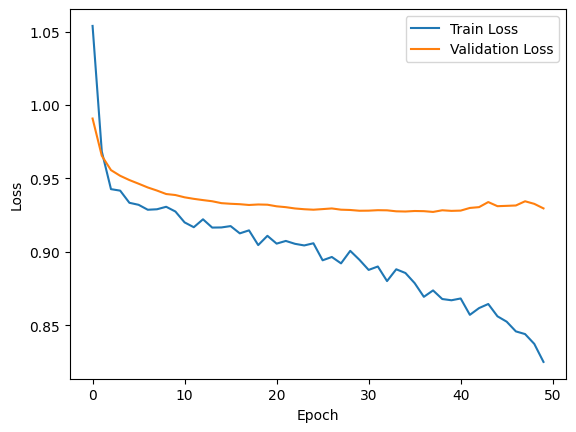

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

12. Đánh giá mô hình:

In [ ]:
# Đánh giá mô hình trên tập validation
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

# Đánh giá mô hình trên tập test
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

# In kết quả đánh giá
print('Evaluation on val/test dataset')
print(f'Val accuracy: {val_acc:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Evaluation on val/test dataset
Val accuracy: 0.5814
Test accuracy: 0.6044


## **Problem 02: Hourly Temperature Forecasting**

In [ ]:
import torch
import torch .nn as nn

seed = 1
torch . manual_seed ( seed )

import numpy as np
import pandas as pd
import matplotlib . pyplot as plt

from torch.utils.data import Dataset

from torch . utils . data import Dataset , DataLoader

In [ ]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


In [ ]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd. read_csv ( dataset_filepath )

In [ ]:
univariate_df = df['Temperature (C)']
univariate_df . index = df['Formatted Date']

In [ ]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    """
    Slices a DataFrame into features and labels using a sliding window approach.

    Parameters:
    df (array-like): Input data.
    df_start_idx (int): Starting index for slicing.
    df_end_idx (int): Ending index for slicing (optional, defaults to None).
    input_size (int): Number of time steps for input features.
    label_size (int): Number of time steps for labels.
    offset (int): Offset between input and label windows.

    Returns:
    Tuple: Numpy arrays for features and labels.
    """
    features = []
    labels = []

    # Calculate the window size for slicing
    window_size = input_size + offset

    # If df_end_idx is None, set it to the maximum valid index
    if df_end_idx is None:
        df_end_idx = len(df) - window_size

    # Sliding window to extract features and labels
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        # Extract feature and label slices
        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]

        features.append(feature)
        labels.append(label)

    # Convert features and labels to numpy arrays
    features = np.expand_dims(np.array(features), axis=-1)
    labels = np.array(labels)

    return features, labels

In [ ]:
# Define dataset splits
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2

# Compute split indices
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

# Training set slicing
X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

# Validation set slicing
X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

# Test set slicing
X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

In [ ]:
class WeatherForecast(Dataset):
    """
    Custom PyTorch Dataset for Weather Forecast data.
    """

    def __init__(self, X, y, transform=None):
        """
        Initializes the WeatherForecast dataset.

        Parameters:
        X (array-like): Input features.
        y (array-like): Target values.
        transform (callable, optional): A function/transform to apply to the input features.
        """
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieves a single sample of data.

        Parameters:
        idx (int): Index of the data to fetch.

        Returns:
        tuple: Transformed input features and target values as torch tensors.
        """
        X = self.X[idx]
        y = self.y[idx]

        # Apply transformation if provided
        if self.transform:
            X = self.transform(X)

        # Convert to PyTorch tensors
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [ ]:
from torch.utils.data import DataLoader

# Initialize datasets
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

# Define batch sizes
train_batch_size = 128
test_batch_size = 8

# Initialize DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [ ]:
class WeatherForecastor(nn.Module):
    """
    A Recurrent Neural Network (RNN)-based model for weather forecasting.
    """

    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        """
        Initializes the WeatherForecastor model.

        Parameters:
        embedding_dim (int): Input feature dimension.
        hidden_size (int): Hidden state size of the RNN.
        n_layers (int): Number of RNN layers.
        dropout_prob (float): Dropout probability.
        """
        super(WeatherForecastor, self).__init__()

        # Define the RNN layer
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True
        )

        # Normalization, Dropout, and Fully Connected layer
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Forward pass of the WeatherForecastor model.

        Parameters:
        x (Tensor): Input tensor of shape (batch_size, seq_length, embedding_dim).

        Returns:
        Tensor: Output tensor of shape (batch_size, 1).
        """
        # Pass through the RNN
        x, _ = self.rnn(x)

        # Extract the last timestep
        x = x[:, -1, :]

        # Apply normalization, dropout, and the fully connected layer
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [ ]:
# Model hyperparameters
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model instantiation
model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

In [ ]:
lr = 1e-3
epochs = 50

criterion = nn. MSELoss ()
optimizer = torch . optim . Adam (model . parameters () ,lr=lr)

In [ ]:
train_losses , val_losses = fit( model ,train_loader , val_loader ,criterion ,optimizer ,device ,epochs)

EPOCH 1:	Train loss: 126.7144	Val loss: 41.0000
EPOCH 2:	Train loss: 29.9093	Val loss: 7.3274
EPOCH 3:	Train loss: 16.1273	Val loss: 3.4272
EPOCH 4:	Train loss: 13.1546	Val loss: 3.0708
EPOCH 5:	Train loss: 11.6122	Val loss: 2.1856
EPOCH 6:	Train loss: 10.6032	Val loss: 1.8872
EPOCH 7:	Train loss: 10.1788	Val loss: 1.7648
EPOCH 8:	Train loss: 9.6495	Val loss: 1.8416
EPOCH 9:	Train loss: 9.3395	Val loss: 2.0046
EPOCH 10:	Train loss: 9.1364	Val loss: 1.6814
EPOCH 11:	Train loss: 8.8933	Val loss: 1.5721
EPOCH 12:	Train loss: 8.8007	Val loss: 1.5610
EPOCH 13:	Train loss: 8.4925	Val loss: 2.1109
EPOCH 14:	Train loss: 8.4098	Val loss: 1.8387
EPOCH 15:	Train loss: 8.2465	Val loss: 1.6703
EPOCH 16:	Train loss: 7.8910	Val loss: 1.9198
EPOCH 17:	Train loss: 7.8164	Val loss: 1.5562
EPOCH 18:	Train loss: 7.7346	Val loss: 1.9940
EPOCH 19:	Train loss: 7.5003	Val loss: 1.5797
EPOCH 20:	Train loss: 7.4499	Val loss: 1.5617
EPOCH 21:	Train loss: 7.2653	Val loss: 1.9261
EPOCH 22:	Train loss: 7.0328	Val l

In [ ]:
val_loss = evaluate ( model , val_loader , criterion , device )
test_loss = evaluate (model ,test_loader , criterion , device )

print ('Evaluation on val/test dataset')
print ('Val loss : ', val_loss )
print ('Test loss :', test_loss )

Evaluation on val/test dataset
Val loss :  (1.519397990293652, 0.005391394504924832)
Test loss : (1.3313042788764393, 0.006639692914202718)


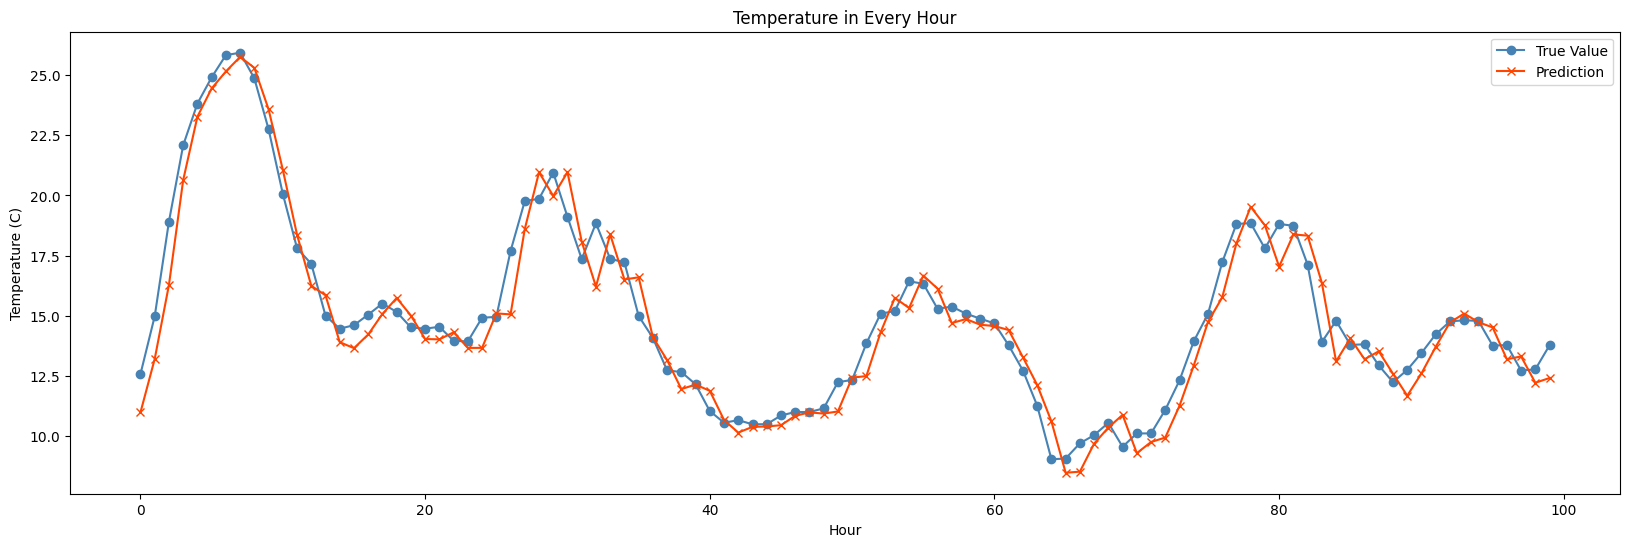

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_difference(y, pred):
    """
    Plots the true values vs. predicted values over time.

    Parameters:
    y (array-like): True values.
    pred (array-like): Predicted values.
    """
    plt.figure(figsize=(20, 6))
    times = range(len(y))

    # Flatten inputs for consistent shape
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    # Plot true and predicted values
    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True Value')
    plt.plot(times, pred_to_plot, color='orangered', marker='x', label='Prediction')

    # Add titles and labels
    plt.title('Temperature in Every Hour')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

# Prepare test inputs
inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

# Model evaluation
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

# Plot true vs. predicted values
plot_difference(y_test[:100], outputs)

In [ ]:
import torch
import torch .nn as nn

input_tensor = torch . randn (5 , 10 , 10)

lstm = nn. LSTM ( input_size =10 , hidden_size =20 , num_layers =2 , batch_first = True )
bilstm = nn. LSTM ( input_size =10 , hidden_size =20 , num_layers =2 , batch_first =True ,bidirectional = True )

output_lstm , ( hidden_state_lstm , cell_state_lstm ) = lstm ( input_tensor )

output_bilstm , ( hidden_state_bilstm , cell_state_bilstm ) = bilstm ( input_tensor )

print ( output_lstm . shape )
print ( output_bilstm . shape )

torch.Size([5, 10, 20])
torch.Size([5, 10, 40])
